In [7]:
%matplotlib inline

def get_statistics(inputdir):
    import os, numpy as np
    from sklearn.metrics import roc_auc_score

    if not os.path.isdir(inputdir): raise SystemExit('Input directory does not exist, exitting!!!')
    
    scores = []
    npz_files = [file for file in os.listdir(inputdir) if file.endswith('.npz')]
    if not len(npz_files) ==0: 
        print(f'Calculating average auc scores from {inputdir}\n')
    else: 
        raise SystemExit()

    for npz in npz_files:
        file_path = os.path.join(inputdir, npz)
        result = np.load(file_path)
        if not ('y_test' in result.files and 'score' in result.files): continue
        score = roc_auc_score(y_score=result['score'], y_true=result['y_test'])
        scores.append(score)
    print(f'Total number of result files: {len(scores)}')
    print(f'AUC scores: {[round(score,2) for score in scores]}')
    print(f'Average score: {np.mean(scores):.2f} +/- {np.std(scores):.2f}')

####################################################################################################################

def plot_averaged_roc(inputdir, save_roc=None, show=False, title=None, figsize = None, inputplot=None, method=''):
    import os, numpy as np
    from sklearn.metrics import roc_auc_score, roc_curve
    import matplotlib.pyplot as plt

    # configure plot
    if not inputplot:
        fig = plt.figure(figsize=figsize if figsize else [5,5])
        ax = fig.add_subplot(1,1,1)
    else: 
        ax = inputplot
    #plt.grid(color='gray', linestyle='-', linewidth=1)
        ax.set_xlabel('Signal acceptance (TPR)')
        ax.set_ylabel('Background rejection (TNR)')
        if title:
            ax.set_title(title)
        else:
            ax.set_title('Receiver operating characteristic')
        ax.set_xbound(-0.03, 1.03)
        ax.set_ybound(-0.03, 1.03)
        ax.set_xticks(np.arange(0, 1.01, 0.1))
        ax.set_yticks(np.arange(0, 1.01, 0.1))
        ax.plot([0, 1], [1, 0], linestyle='--', color='navy', label='Luck')

    if not os.path.isdir(inputdir): raise SystemExit('Input directory does not exist, exitting!!!')
    print(f'Plotting averaged roc curve from {inputdir}\n')

    rocs = []
    tpr = np.linspace(0,1,100)
    for npz in [file for file in os.listdir(inputdir) if file.endswith('.npz')]:
        file_path = os.path.join(inputdir, npz)
        result = np.load(file_path)
        if not ('y_test' in result.files and 'score' in result.files): continue
        score = roc_auc_score(y_score=result['score'], y_true=result['y_test'])
        fpr_, tpr_, thresholds_ = roc_curve(y_score=result['score'], y_true=result['y_test'])
        tnr_ = 1 - fpr_
        tnr = np.interp(x=tpr, xp=tpr_, fp=tnr_)
        roc = {'score': score, 'tpr': tpr, 'tnr': tnr}
        rocs.append(roc)
    
    rocs.sort(key = lambda x: x['score'])
    mean_tnr = np.mean([roc['tnr'] for roc in rocs], axis = 0)
    mean_tnr[0] = 1
    std_tnr = np.std([roc['tnr'] for roc in rocs], axis = 0)

    mean_auc = np.mean([roc['score'] for roc in rocs])
    std_auc = np.std([roc['score'] for roc in rocs])

    ax.plot(tpr, mean_tnr, #color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)
    upper_tnr = np.minimum(mean_tnr + std_tnr, 1)
    lower_tnr = np.maximum(mean_tnr - std_tnr, 0)
    ax.fill_between(tpr, lower_tnr, upper_tnr, color='grey', alpha=.2 #, label=r'$\pm$ 1 std. dev.'
                    )
    
    ax.plot(tpr, rocs[0]['tnr'], alpha = 0.7, label = f'Best performance {method}, AUC = {rocs[0]["score"]:.2f}', lw = 1)
    ax.plot(tpr, rocs[-1]['tnr'], alpha = 0.7, label = f'Worst performance {method}, AUC = {rocs[-1]["score"]:.2f}', lw = 1)
    ax.legend(loc='lower left', framealpha=0.5)
    #plt.show()

    if save_roc:
        save_path = os.path.dirname(save_roc)
        if len(save_path)!=0 and not os.path.isdir(save_path): os.makedirs(save_path)
        if not (save_roc.endswith('.pdf') or save_roc.endswith('.png')): save_roc+='.png'
        plt.savefig(save_roc)
        print(f'Path to saved file: {save_roc}')
        print('_'*20)

    if show: 
        plt.show()
    #plt.clf()

    return ax
####################################################################################################################

def plot_multiple_ROC(inputs, save_roc=None, show=False, weight_train=None, weight_val=None, title=None, figsize=None):
    import os, numpy as np
    from sklearn.metrics import roc_auc_score, roc_curve
    import matplotlib.pyplot as plt

    # configure plot
    plt.figure(figsize=figsize if figsize else [7.5,7.5])
    #plt.grid(color='gray', linestyle='-', linewidth=1)
    plt.xlabel('Signal acceptance (TPR)')
    plt.ylabel('Background rejection (TNR)')
    if title:
        plt.title(title)
    else:
        plt.title('Receiver operating characteristic')
    plt.xlim(-0.03, 1.03)
    plt.ylim(-0.03, 1.03)
    plt.xticks(np.arange(0, 1.01, 0.1))
    plt.yticks(np.arange(0, 1.01, 0.1))
    plt.plot([0, 1], [1, 0], linestyle='--', color='navy', label='Luck')

    for input in inputs:
        if not ('inputdir' in input.keys() and 'method' in input):
            print('Elements in inputs must be a dict containing inputdir and method name')
            continue
        inputdir, method = input['inputdir'], input['method']

        if not os.path.isdir(inputdir): 
            print(f'Input directory {inputdir} does not exist!!!')
            continue
        print(f'Plotting averaged roc curve from {inputdir}\n')

        rocs = []
        tpr = np.linspace(0,1,100)
        for npz in [file for file in os.listdir(inputdir) if file.endswith('.npz')]:
            file_path = os.path.join(inputdir, npz)
            result = np.load(file_path)
            if not ('y_test' in result.files and 'score' in result.files): continue
            score = roc_auc_score(y_score=result['score'], y_true=result['y_test'])
            fpr_, tpr_, thresholds_ = roc_curve(y_score=result['score'], y_true=result['y_test'])
            tnr_ = 1 - fpr_
            tnr = np.interp(x=tpr, xp=tpr_, fp=tnr_)
            roc = {'score': score, 'tpr': tpr, 'tnr': tnr}
            rocs.append(roc)

        mean_tnr = np.mean([roc['tnr'] for roc in rocs], axis = 0)
        mean_tnr[0] = 1
        
        mean_auc = np.mean([roc['score'] for roc in rocs])
        std_auc = np.std([roc['score'] for roc in rocs])

        plt.plot(tpr, mean_tnr,
        label=r'Mean ROC %s (AUC = %0.2f $\pm$ %0.2f)' % (method, mean_auc, std_auc),
        lw=2, alpha=.8)

    plt.legend(loc='lower left', framealpha=0.5)

    if save_roc:
        save_path = os.path.dirname(save_roc)
        if len(save_path)!=0 and not os.path.isdir(save_path): os.makedirs(save_path)
        if not (save_roc.endswith('.pdf') or save_roc.endswith('.png')): save_roc+='.png'
        plt.savefig(save_roc)
        print(f'Path to saved file: {save_roc}')
        print('_'*20)

    if show: plt.show()

    plt.clf()
    return

Plotting averaged roc curve from outputs/xgboost/samples_1400-600_signal_mass_point/monohbb_100_events_without_PolyFeature

Plotting averaged roc curve from outputs/qsvm/samples_1400-600_signal_mass_point/FirstOrderExpansion_100events_depth1_without_PolyFeature_nqubits4



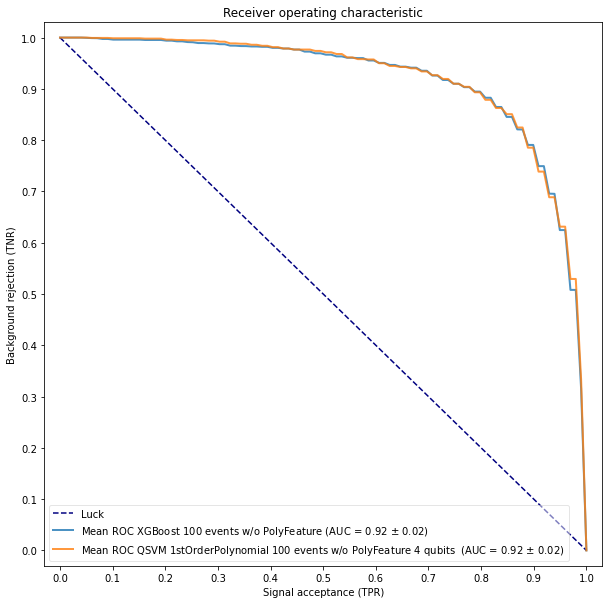

Plotting averaged roc curve from outputs/xgboost/samples_1400-600_signal_mass_point/monohbb_200_events_without_PolyFeature

Plotting averaged roc curve from outputs/qsvm/samples_1400-600_signal_mass_point/FirstOrderExpansion_200events_depth1_without_PolyFeature_nqubits4



<Figure size 432x288 with 0 Axes>

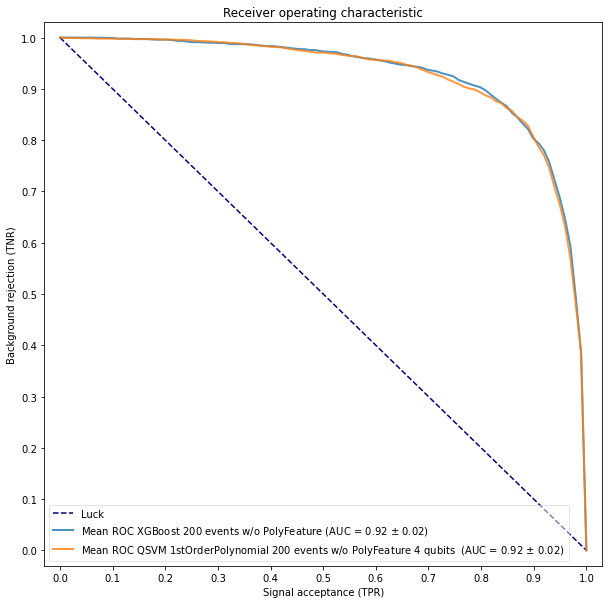

Plotting averaged roc curve from outputs/xgboost/samples_1400-600_signal_mass_point/monohbb_400_events_without_PolyFeature

Plotting averaged roc curve from outputs/qsvm/samples_1400-600_signal_mass_point/FirstOrderExpansion_400events_depth1_without_PolyFeature_nqubits4



<Figure size 432x288 with 0 Axes>

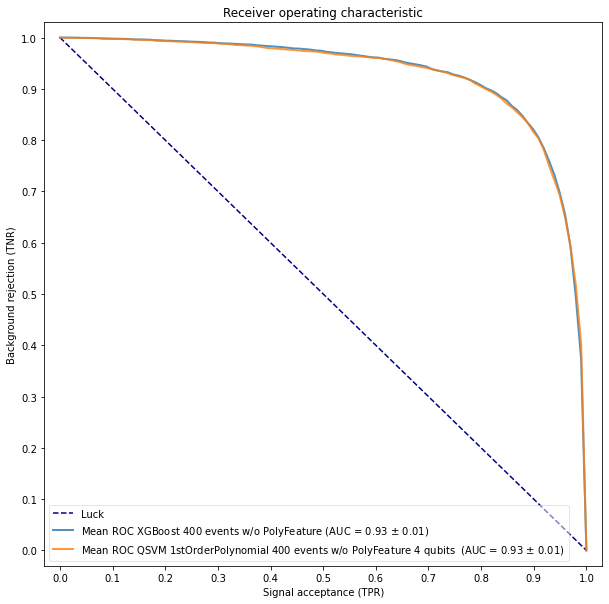

Plotting averaged roc curve from outputs/xgboost/samples_1400-600_signal_mass_point/monohbb_600_events_without_PolyFeature

Plotting averaged roc curve from outputs/qsvm/samples_1400-600_signal_mass_point/FirstOrderExpansion_600events_depth1_without_PolyFeature_nqubits4



<Figure size 432x288 with 0 Axes>

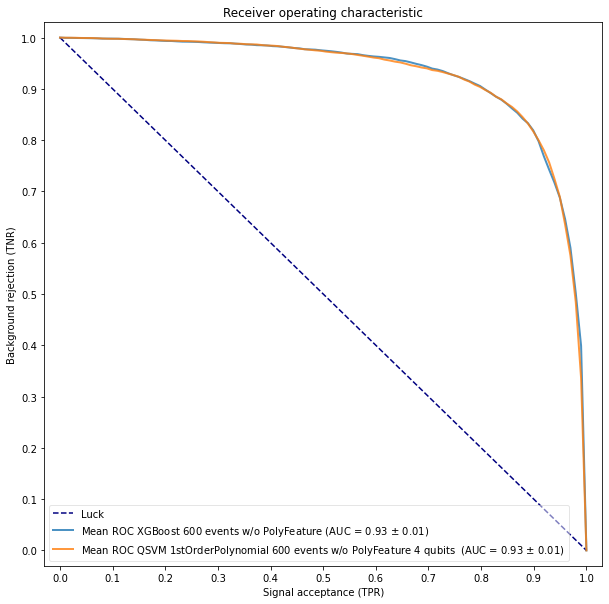

<Figure size 432x288 with 0 Axes>

In [6]:
inputs = []
event_numbers = [100,200,400,600]

for event_number in event_numbers:
    bdt = {'inputdir': f'outputs/xgboost/samples_1400-600_signal_mass_point/monohbb_{event_number}_events_without_PolyFeature', 'method': f'XGBoost {event_number} events w/o PolyFeature'}
    qsvm = {'inputdir': f'outputs/qsvm/samples_1400-600_signal_mass_point/FirstOrderExpansion_{event_number}events_depth1_without_PolyFeature_nqubits4', 'method': f'QSVM 1stOrderPolynomial {event_number} events w/o PolyFeature 4 qubits '}
    
    inputs.append([bdt,qsvm])

for input in inputs:
    plot_multiple_ROC(input, show=True, figsize = [10,10])

Plotting averaged roc curve from outputs/qsvm/samples_1400-600_signal_mass_point/FirstOrderExpansion_100events_depth1_without_PolyFeature_nqubits4

Path to saved file: test.png
____________________
Plotting averaged roc curve from outputs/qsvm/samples_1400-600_signal_mass_point/FirstOrderExpansion_600events_depth1_without_PolyFeature_nqubits4



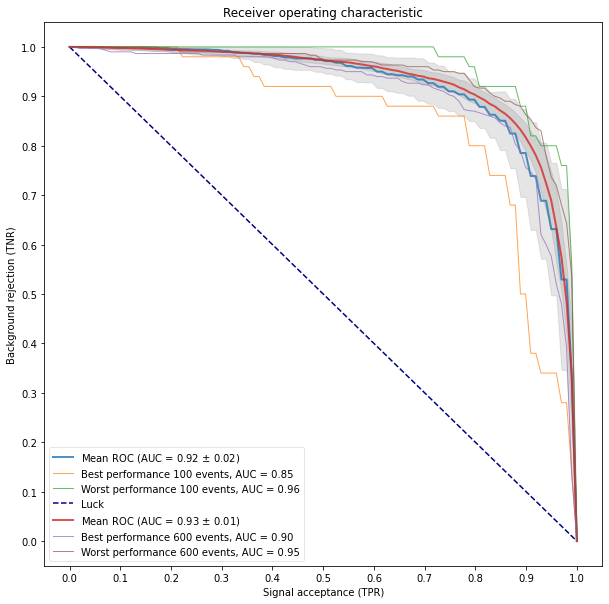

In [8]:
ax = plot_averaged_roc(inputdir='outputs/qsvm/samples_1400-600_signal_mass_point/FirstOrderExpansion_100events_depth1_without_PolyFeature_nqubits4', save_roc='test.png',figsize=[10,10], method='100 events')
ax = plot_averaged_roc(inputdir='outputs/qsvm/samples_1400-600_signal_mass_point/FirstOrderExpansion_600events_depth1_without_PolyFeature_nqubits4', inputplot=ax, method = '600 events')

In [30]:
ax

In [4]:
path = 'outputs/qsvm/samples_1400-600_signal_mass_point/SecondOrderExpansion'
for dir in [os.path.join(path, dir) for dir in os.listdir(path)]:
    get_statistics(dir)
    print('\n')

Calculating average auc scores from outputs/qsvm/samples_1400-600_signal_mass_point/SecondOrderExpansion/200events_depth1_entanglementfull_nqubits4

Total number of result files: 25
AUC scores: [0.86, 0.87, 0.88, 0.82, 0.86, 0.82, 0.92, 0.87, 0.89, 0.88, 0.95, 0.92, 0.89, 0.81, 0.9, 0.95, 0.86, 0.85, 0.88, 0.88, 0.9, 0.8, 0.9, 0.93, 0.84]
Average score: 0.88 +/- 0.04


Calculating average auc scores from outputs/qsvm/samples_1400-600_signal_mass_point/SecondOrderExpansion/400events_depth1_entanglementfull_nqubits4

Total number of result files: 13
AUC scores: [0.92, 0.91, 0.89, 0.86, 0.93, 0.91, 0.88, 0.91, 0.9, 0.92, 0.89, 0.88, 0.89]
Average score: 0.90 +/- 0.02


Calculating average auc scores from outputs/qsvm/samples_1400-600_signal_mass_point/SecondOrderExpansion/600events_depth1_entanglementfull_nqubits4

Total number of result files: 24
AUC scores: [0.86, 0.92, 0.89, 0.89, 0.92, 0.92, 0.91, 0.9, 0.91, 0.9, 0.91, 0.9, 0.92, 0.91, 0.9, 0.89, 0.9, 0.91, 0.91, 0.89, 0.92, 0.91, 0.9

In [72]:
parent = 'outputs/qsvm/samples_1400-600_signal_mass_point'
paths = [os.path.join(parent, dir) for dir in os.listdir(parent)]
for path in paths:
    figure_title = path.split('/')[-1].replace('depth1_', '')
    save_roc = os.path.join(path.replace(path.split('/')[-1], 'averaged_roc_plots').replace('outputs', 'roc_plots'), figure_title)
    plot_averaged_roc(inputdir = path, save_roc = path.replace('depth1_', ''), title=figure_title)


Plotting averaged roc curve from outputs/qsvm/samples_1400-600_signal_mass_point/FirstOrderExpansion_100events_depth1_without_PolyFeature_nqubits8

Path to saved file: outputs/qsvm/samples_1400-600_signal_mass_point/FirstOrderExpansion_100events_without_PolyFeature_nqubits8.png
____________________
Plotting averaged roc curve from outputs/qsvm/samples_1400-600_signal_mass_point/FirstOrderExpansion_100events_depth1_with_PolyFeature_nqubits8

Path to saved file: outputs/qsvm/samples_1400-600_signal_mass_point/FirstOrderExpansion_100events_with_PolyFeature_nqubits8.png
____________________
Plotting averaged roc curve from outputs/qsvm/samples_1400-600_signal_mass_point/FirstOrderExpansion_100events_depth1_without_PolyFeature_nqubits4

Path to saved file: outputs/qsvm/samples_1400-600_signal_mass_point/FirstOrderExpansion_100events_without_PolyFeature_nqubits4.png
____________________
Plotting averaged roc curve from outputs/qsvm/samples_1400-600_signal_mass_point/FirstOrderExpansion_2

SystemExit: Input directory does not exist, exitting!!!